# Models profiling

## Import libraries and models

In [1]:
import mlflow

import pandas as pd
import numpy as np
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# ['minmax_amt_gms', 'rt_claims_year', 'rt_premiums_year', 'sqrt_amt_gms', 'PCA2_', 'atr_credit_score_proxy', 'atr_cust_age'] 42b05ce5d54241f483974e564757e97e
# ['norm_amt_gms', 'rt_premiums_year', 'rt_claims_year', 'atr_credit_score_proxy', 'minmax_atr_cust_age', 'PCA2_', 'atr_cust_age'] 2ad5c2d2063b42c090ab80a5b9704402

In [3]:
DATA_PATH = "../data/20220418-153507_dataset.csv"
dfInsurance = pd.read_csv(DATA_PATH)

In [4]:
dfInsurance.columns

Index(['cod_cust_id', 'dt_fpy', 'atr_cust_age', 'dsc_edu_deg', 'amt_gms',
       'atr_gla', 'flg_children', 'amt_cmv', 'rt_cr', 'amt_plob_motor',
       ...
       'PCA1_3', 'PCA1_4', 'PCA1_5', 'PCA1_6', 'PCA2_', 'PCA2_2', 'PCA2_3',
       'PCA2_4', 'PCA2_5', 'PCA2_6'],
      dtype='object', length=104)

## SCORER Model

We went with a more manual approach, with the help of MLFlow

### Train

In [5]:
dbscan_kwargs = {
            "eps":0.045,
            "metric": "euclidean",
            "algorithm": 'kd_tree',
            "min_samples": 17}
dbscan_model = DBSCAN(**dbscan_kwargs)
dbscan_model.fit(dfInsurance[['log_rt_plob_household', 'log_rt_plob_motor', 'rt_premiums_year', 'rt_plob_household', 'log_rt_plob_wcomp', 'rt_cr']])
dfInsurance['SCORER_DBSCAN_1'] = dbscan_model.labels_
dfInsurance['SCORER_DBSCAN_1'].value_counts()

-1    5194
 0    4874
 1      58
 5      27
 4      25
 2      22
 3      16
 7      15
 6      13
Name: SCORER_DBSCAN_1, dtype: int64

In [6]:
# https://stackoverflow.com/questions/39109045/numpy-where-with-multiple-conditions
conditions = [(dfInsurance['SCORER_DBSCAN_1'] == -1) & (dfInsurance['atr_cust_age'] < 49), 
              (dfInsurance['SCORER_DBSCAN_1'] == -1) & (dfInsurance['atr_cust_age'] >= 49), 
              (dfInsurance['SCORER_DBSCAN_1'] == 0) & (dfInsurance['amt_cmv'] < 250),
              (dfInsurance['SCORER_DBSCAN_1'] == 0) & (dfInsurance['amt_cmv'] >= 250)]
choices = [ "Young-AvgCMV", 'Old-AvgCMV', 'MiddleAge-LowCMV', 'MiddleAge-HighCMV']

dfInsurance["SCORER_CLUSTER"] = np.select(conditions, choices, default='Others')

### Profiling

In [7]:
A = ['atr_cust_age', 'amt_gms', 'amt_cmv', 'amt_premium_total', 'flg_children', 'atr_gla']
B = ['amt_plob_motor', 'amt_plob_household', 'amt_plob_life', 'amt_plob_health', 'amt_plob_wcomp','flg_children', 'atr_gla']

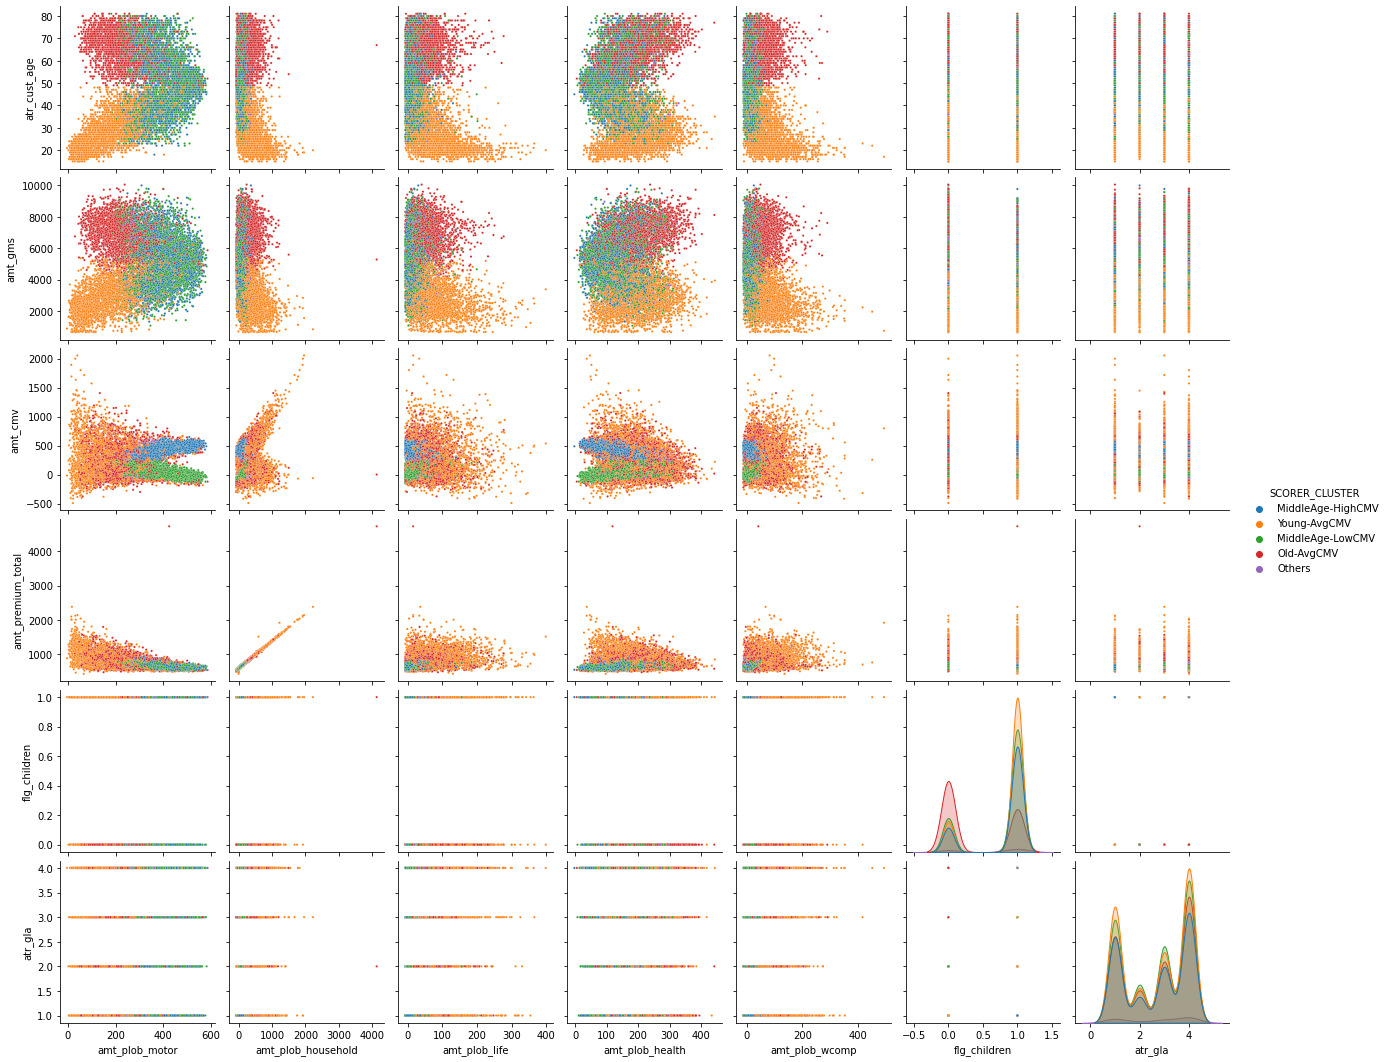

In [8]:
pp = sns.pairplot(data=dfInsurance,
                  y_vars= A,
                  x_vars= B,
                 hue = 'SCORER_CLUSTER', palette='tab10', plot_kws={'s':5})

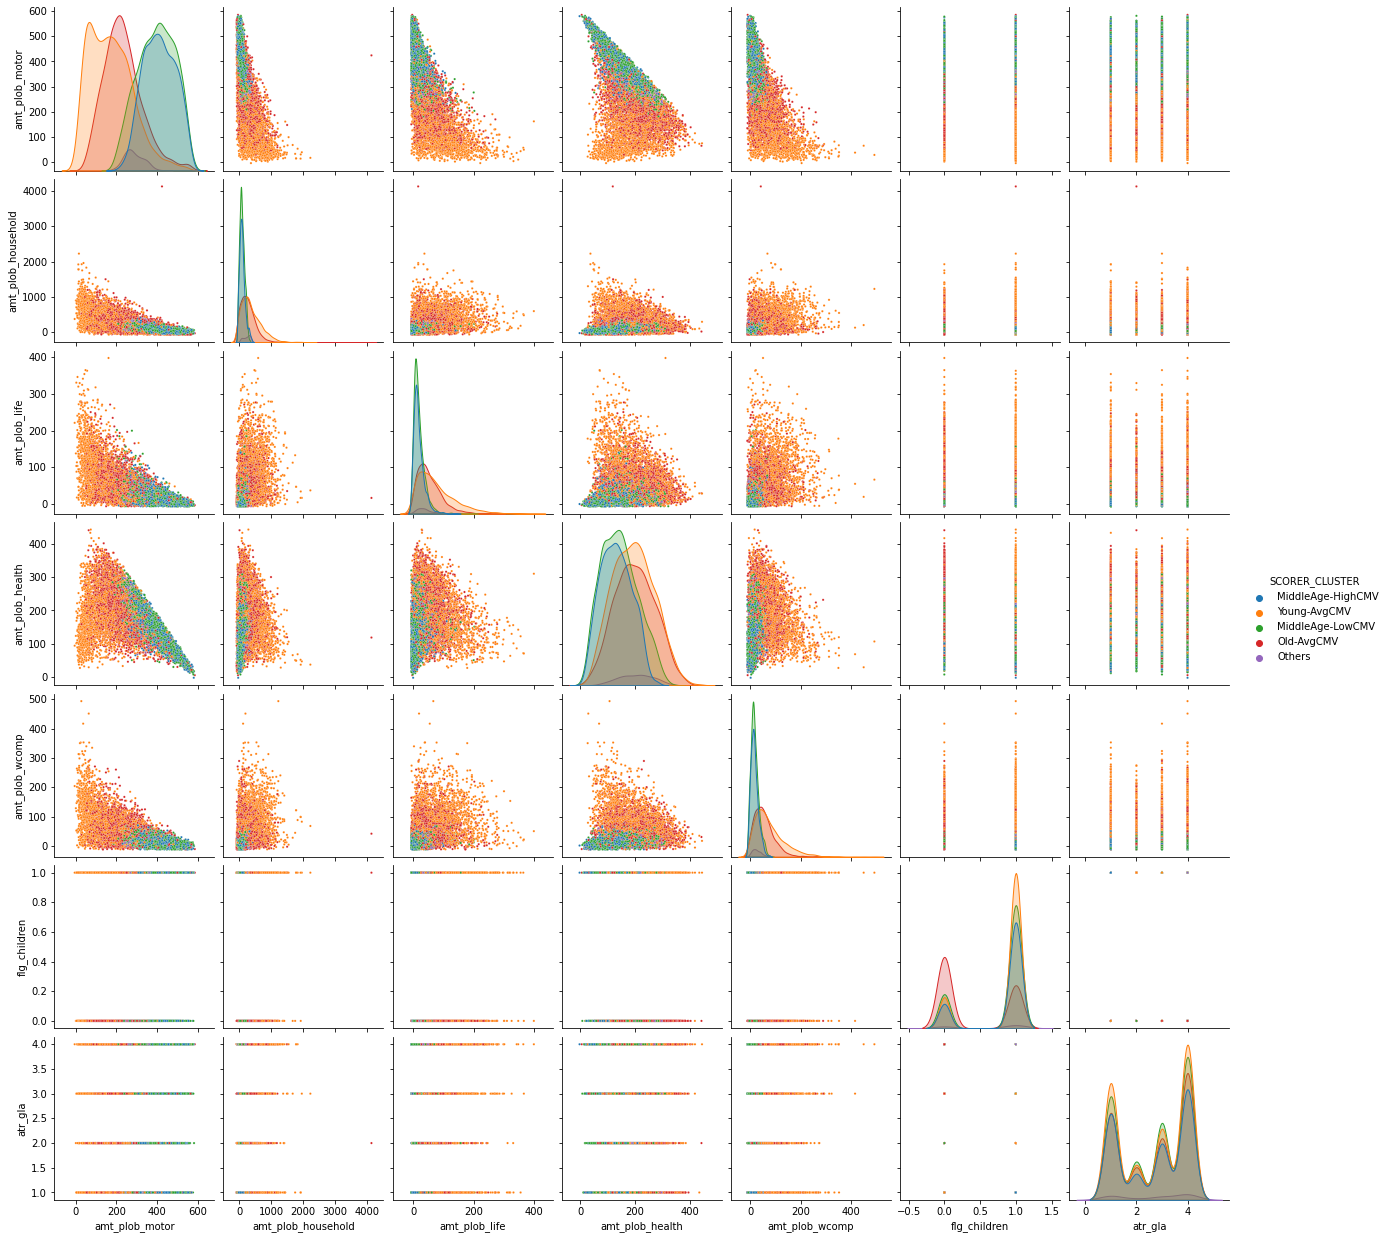

In [9]:
pp = sns.pairplot(data=dfInsurance,
                  y_vars= B,
                  x_vars= B,
                 hue = 'SCORER_CLUSTER', palette='tab10', plot_kws={'s':5})

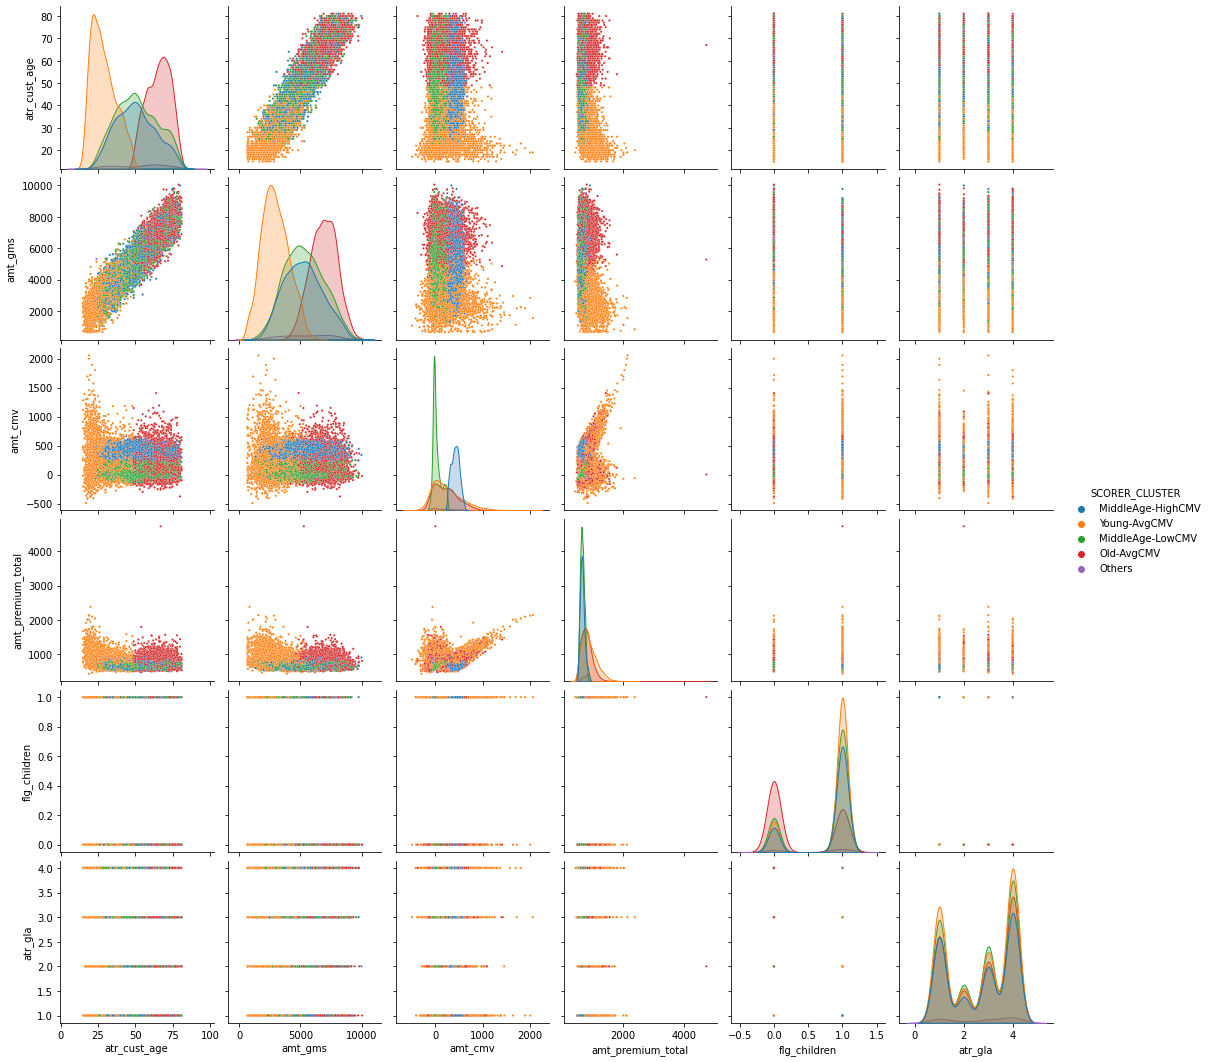

In [10]:
pp = sns.pairplot(data=dfInsurance,
                  y_vars= A,
                  x_vars= A,
                 hue = 'SCORER_CLUSTER', palette='tab10', plot_kws={'s':5})

In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
METRIC_FEATURES = ['atr_cust_age', 'amt_gms', 'amt_cmv', 'amt_premium_total']

print(silhouette_score(dfInsurance[METRIC_FEATURES],dfInsurance["SCORER_CLUSTER"]))
print(calinski_harabasz_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_CLUSTER"]))
print(davies_bouldin_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_CLUSTER"]))

0.0672445363640417
2745.7496201239596
6.808735174834996


In [15]:
dfInsurance["SCORER_CLUSTER"].value_counts()

Young-AvgCMV         2841
MiddleAge-LowCMV     2681
Old-AvgCMV           2353
MiddleAge-HighCMV    2193
Others                176
Name: SCORER_CLUSTER, dtype: int64

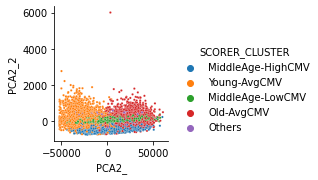

In [16]:
pp = sns.pairplot(data=dfInsurance,
                  x_vars= ['PCA2_'],
                  y_vars= ['PCA2_2'],
                 hue = 'SCORER_CLUSTER', palette='tab10', plot_kws={'s':5})

And the means by cluster are the following



In [52]:
for i in dfInsurance['SCORER_CLUSTER'].unique():
    print(f'Cluster of clients: {i}')
    print("Average age for customers in cluster {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['atr_cust_age']).mean()))
    print("Mean for annual income (in thousends) for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_gys']).mean()))
    print("Mean Customer Monetary Value for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_cmv']).mean()))
    print("Standard deviation of Customer Monetary Value for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_cmv']).std()))
    print("Mean Total Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_premium_total']).mean()))
    print("Standard deviation Total Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_premium_total']).std()))
    print("Mean Motor Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_plob_motor']).mean()))
    print("Mean Household Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_plob_household']).mean()))
    print("Mean Life Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_plob_life']).mean()))
    print("Mean Health Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_plob_health']).mean()))
    print("Mean Work Compensation Premium for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['amt_plob_wcomp']).mean()))
    print("Mean Claims Ratio for customers {}: {}".format(i, np.array(dfInsurance.loc[dfInsurance['SCORER_CLUSTER'] == i]['rt_cr']).mean()))
    print('\n')
          
# print("Deviation of the mean for annual income (in thousends) for customers in cluster zero: {}".format(np.array(clusters[0]['Annual Income (k$)']).std()))
# print("In cluster zero we have: {} customers".format(clusters[0].shape[0]))
# print("From those customers we have {} male and {} female".format(clusters[0].loc[(clusters[0]['Genre'] == 1.0)].shape[0], clusters[0].loc[(clusters[0]['Genre'] == 0.0)].shape[0]))

Cluster of clients: MiddleAge-HighCMV
Average age for customers in cluster MiddleAge-HighCMV: 50.102599179206564
Mean for annual income (in thousends) for customers MiddleAge-HighCMV: 62759.02708618331
Mean Customer Monetary Value for customers MiddleAge-HighCMV: 413.94212494300047
Standard deviation of Customer Monetary Value for customers MiddleAge-HighCMV: 85.1034126219311
Mean Total Premium for customers MiddleAge-HighCMV: 659.3705626994985
Standard deviation Total Premium for customers MiddleAge-HighCMV: 75.7732166273209
Mean Motor Premium for customers MiddleAge-HighCMV: 409.6445690834473
Mean Household Premium for customers MiddleAge-HighCMV: 87.59924760601916
Mean Life Premium for customers MiddleAge-HighCMV: 16.804237118103053
Mean Health Premium for customers MiddleAge-HighCMV: 130.62419607843137
Mean Work Compensation Premium for customers MiddleAge-HighCMV: 14.967071591427269
Mean Claims Ratio for customers MiddleAge-HighCMV: 0.3232288318154035


Cluster of clients: Young-A

## LOVES Model

### Train

In [17]:
METRIC_FEATURES = ['amt_plob_motor', 'amt_plob_household', 'amt_plob_life', 'amt_plob_health', 'amt_plob_wcomp', 'amt_cmv']

In [18]:
B = ['atr_cust_age', 'amt_gms', 'amt_cmv', 'amt_premium_total', 'flg_children', 'atr_gla']
A = ['amt_plob_motor', 'amt_plob_household', 'amt_plob_life', 'amt_plob_health', 'amt_plob_wcomp', 'amt_cmv']

In [19]:
mlflow.set_experiment(experiment_name = "LOVES Model")

KM_EXPERIMENT = mlflow.get_experiment_by_name("LOVES Model")

In [20]:
METRIC_FEATURES = ['amt_plob_motor', 'amt_plob_household', 'amt_plob_life', 'amt_plob_health', 'amt_plob_wcomp', 'amt_cmv']

mlflow.start_run(run_name='AC_final')
mlflow.set_tag("MODEL.TYPE", "AgglomerativeClustering")
mlflow.set_tag("MODEL.NAME", "LOVES")

FEATURES = ['fe_bin_int_cust_age', 'fe_amt_plob_health_scale', 'norm_fpy_to_date', 'fe_amt_plob_life_scale', 'norm_amt_premium_total','fe_amt_plob_household_scale', 'fe_amt_plob_motor_scale']

agglomerative_kwargs = {
            "linkage": "average",
            "affinity": 'euclidean'}
AC_model = AgglomerativeClustering(n_clusters = 6, **agglomerative_kwargs)
AC_model.fit(dfInsurance[FEATURES])
predictions = AC_model.labels_


mlflow.log_params(agglomerative_kwargs)
mlflow.log_param('features', FEATURES)
mlflow.log_param('n_clusters', 6)

mlflow.log_metric('silhouette_score', silhouette_score(dfInsurance[METRIC_FEATURES], predictions))
mlflow.log_metric('ch_score', calinski_harabasz_score(dfInsurance[METRIC_FEATURES], predictions))
mlflow.log_metric('db_score', davies_bouldin_score(dfInsurance[METRIC_FEATURES], predictions))

mlflow.sklearn.log_model(AC_model, artifact_path = 'loves_model')
mlflow.end_run()

In [21]:
dfInsurance['LOBS_CLUSTER'] = AC_model.labels_
dfInsurance['LOBS_CLUSTER'].value_counts()

5    4669
0    3723
2    1195
4     419
1     237
3       1
Name: LOBS_CLUSTER, dtype: int64

In [22]:
mlflow.end_run()

### Profiling

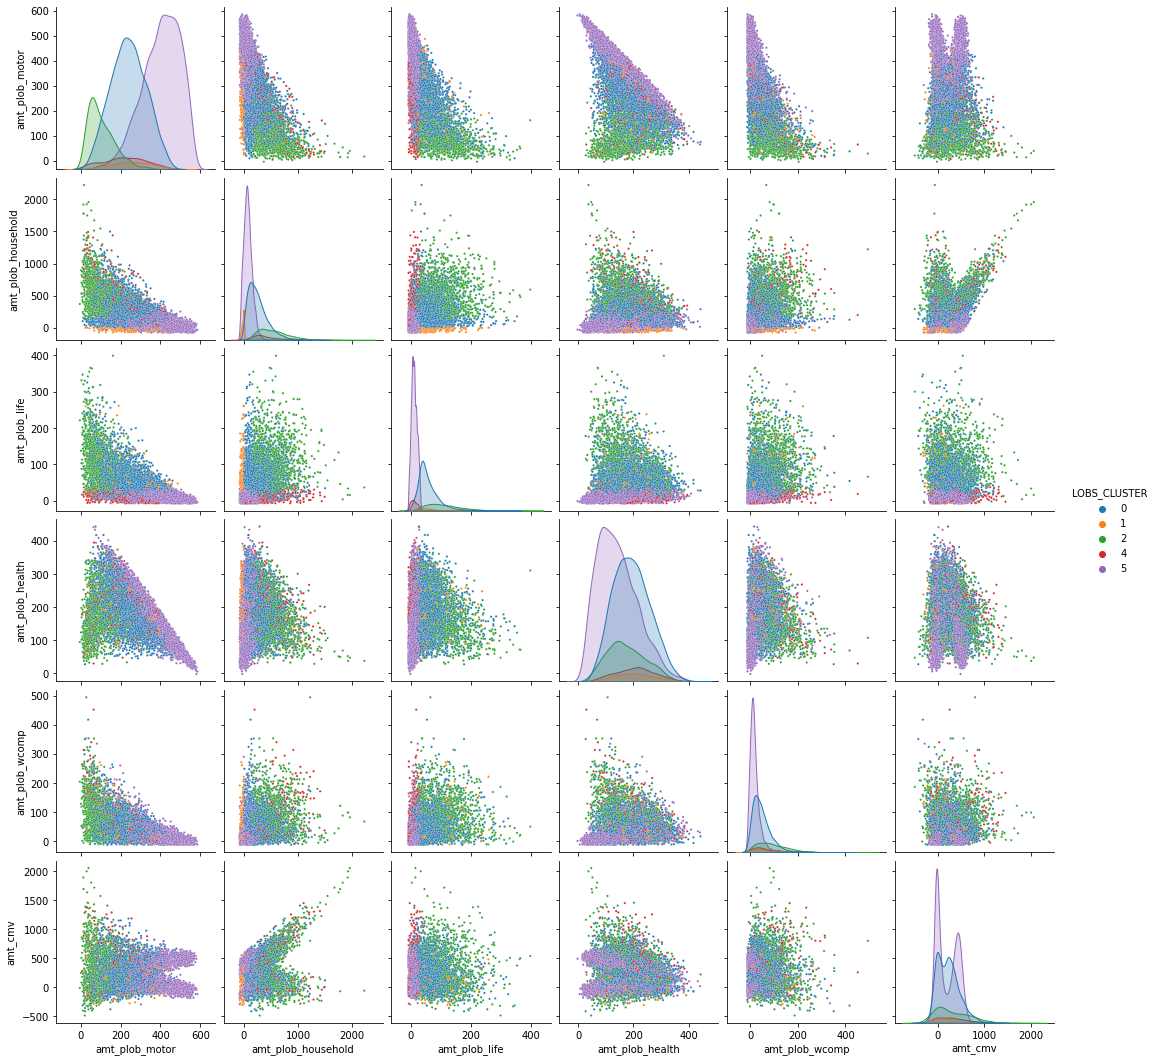

In [23]:
pp = sns.pairplot(data=dfInsurance.loc[dfInsurance['amt_plob_household'] < 4000],
                  y_vars= A,
                  x_vars= A,
                 hue = 'LOBS_CLUSTER', palette='tab10', plot_kws={'s':5})

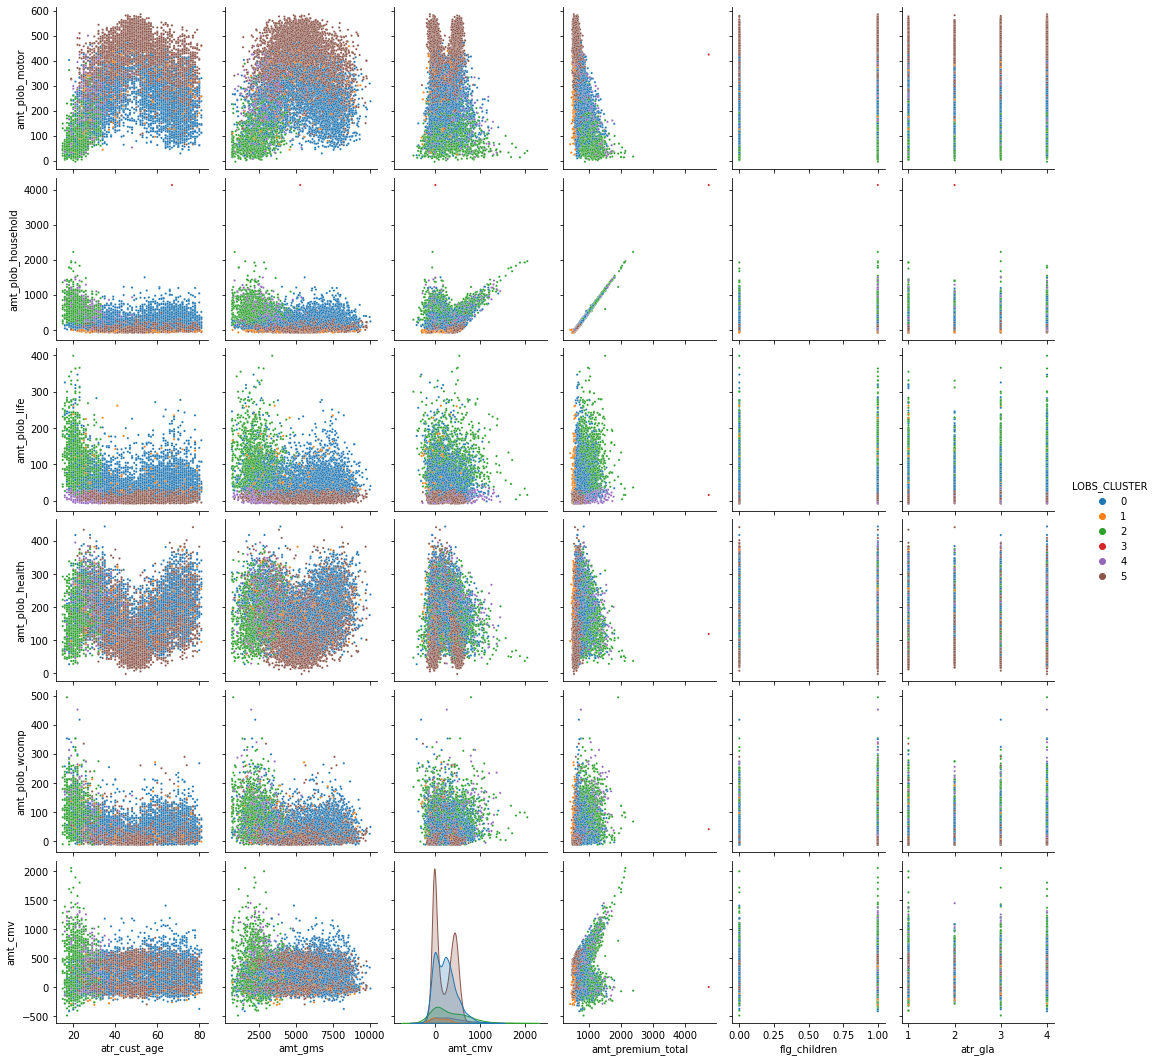

In [24]:
pp = sns.pairplot(data=dfInsurance,
                  y_vars= A,
                  x_vars= B,
                 hue = 'LOBS_CLUSTER', palette='tab10', plot_kws={'s':5})

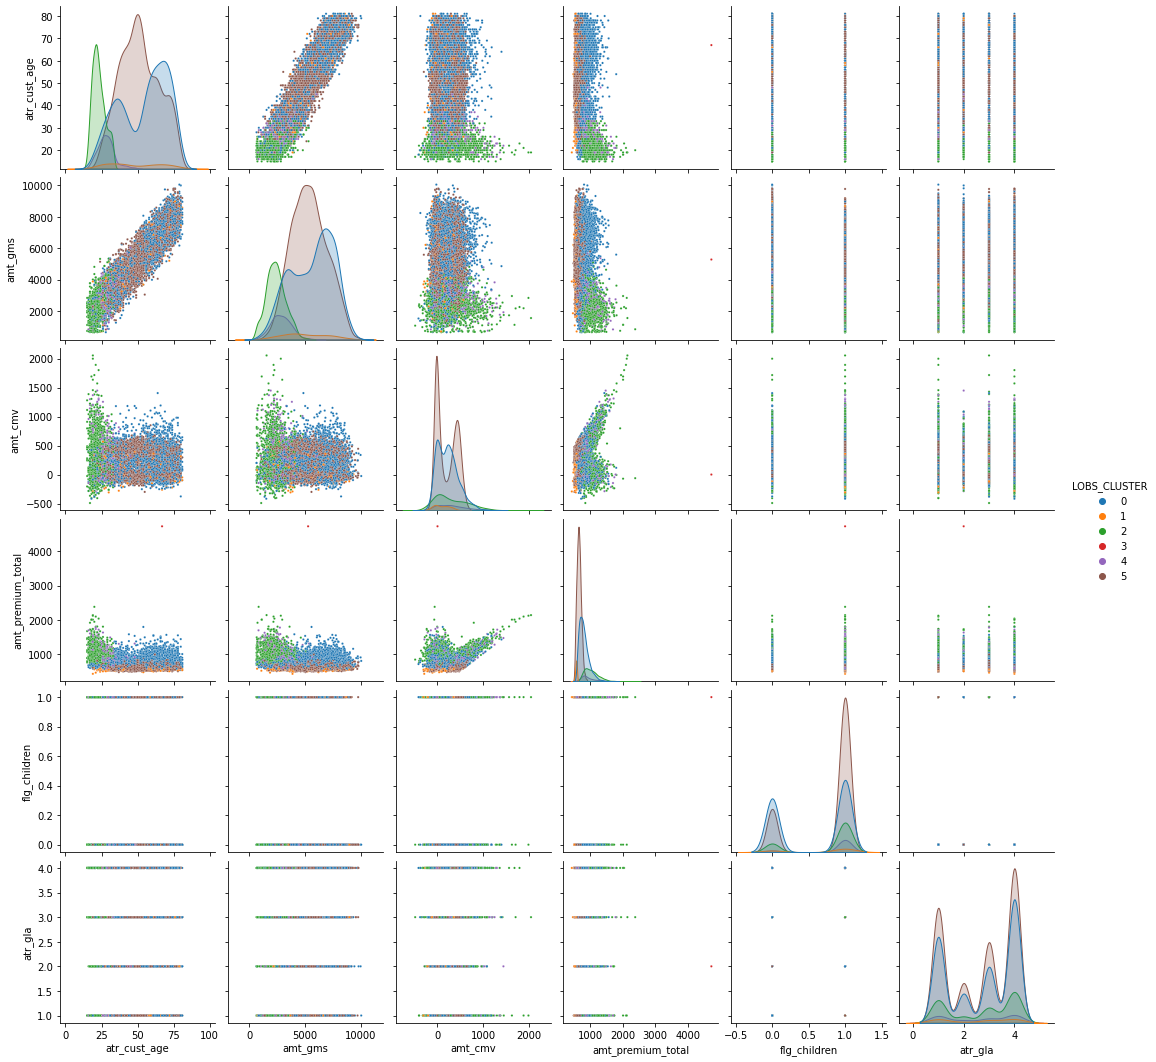

In [25]:
pp = sns.pairplot(data=dfInsurance,
                  y_vars= B,
                  x_vars= B,
                 hue = 'LOBS_CLUSTER', palette='tab10', plot_kws={'s':5})

## Models Metrics

In [146]:
METRIC_FEATURES = ['amt_plob_motor', 'amt_plob_household', 'amt_plob_life', 'amt_plob_health', 'amt_plob_wcomp', 'amt_cmv']
print(silhouette_score(dfInsurance[METRIC_FEATURES],dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print(calinski_harabasz_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print(davies_bouldin_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print('\n')
print(silhouette_score(dfInsurance[METRIC_FEATURES],dfInsurance["LOVES_AG_1"]))
print(calinski_harabasz_score(dfInsurance[METRIC_FEATURES], dfInsurance["LOVES_AG_1"]))
print(davies_bouldin_score(dfInsurance[METRIC_FEATURES], dfInsurance["LOVES_AG_1"]))

0.08403650118930953
1081.2921049640788
4.565140979273643


-0.02430182344921211
724.7713000765652
2.936078522726345


In [147]:
METRIC_FEATURES = ['atr_cust_age', 'amt_gms', 'amt_cmv', 'amt_premium_total']
print(silhouette_score(dfInsurance[METRIC_FEATURES],dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print(calinski_harabasz_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print(davies_bouldin_score(dfInsurance[METRIC_FEATURES], dfInsurance["SCORER_DBSCAN_1_DERIVADO"]))
print('\n')
print(silhouette_score(dfInsurance[METRIC_FEATURES],dfInsurance["LOVES_AG_1"]))
print(calinski_harabasz_score(dfInsurance[METRIC_FEATURES], dfInsurance["LOVES_AG_1"]))
print(davies_bouldin_score(dfInsurance[METRIC_FEATURES], dfInsurance["LOVES_AG_1"]))

0.0672445363640417
2745.7496201239605
6.808735174834996


-0.09718211812654544
1225.0360975735837
4.002985023223829


In [30]:
dfInsurance.to_csv('../data/data_with_clusters.csv', index = False)